In [75]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.ndimage.filters import gaussian_filter1d, uniform_filter1d, median_filter
import warnings
warnings.filterwarnings('ignore')

#Import libraries for Deep Learning
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam

print ('Libraries Loaded!')

Libraries Loaded!


In [76]:
import wfdb as wf
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
import pylab as plt
import numpy as np

%matplotlib inline

In [77]:
# wf.dldatabase('mitdb', '/home/nick/Desktop/Electrocardiogram/Data')

In [78]:
paths = glob('Data/*.dat')
paths = [path[:-4] for path in paths]
paths.sort()

In [79]:
beat_annotations = ['N', 'L', 'R', 'B',
                    'A', 'a', 'J', 'S', 'V',
                    'r', 'F', 'e', 'j', 'n',
                    'E', '/', 'f', 'Q', '?'] 
# 0.5 of how much signal we want per beat
half_qrs = 150

In [80]:
# Prepare the final container
base = pd.DataFrame()

for path in tqdm(paths):
    print('Working with file:', path)
    ann = wf.rdann(path, 'atr')
    print (pd.DataFrame(ann.aux_note)[0].value_counts())
    record = wf.rdsamp(path)
    print("Record :",record)
    # We want just the signals
    data = record[0]
    
    # Prepare containers
    signals, classes = [], []
    # Beat extraction
    for it, beat in enumerate(ann.symbol):#enumerate(ann.anntype)
        if beat in beat_annotations:
            # Defend from the dumb annotation hacking my folder structure
            if beat == '/': beat = 'C'
                
            sta = ann.sample[it-1] - half_qrs
            end = ann.sample[it-1] + half_qrs
            qrs = data[sta : end, :]
            # This may happen at the edges
            if len(qrs) != 2 * half_qrs: continue
            
            # Keep the channel type in the class name
            for ch in range(2):
                beat_class = '{}_{}'.format(record[1]['sig_name'][ch], beat)
                signals.append(qrs[:, ch])
                classes.append(beat_class)
                
    new_frame = pd.DataFrame({'qrs_data' : signals,
                              'qrs_type' : classes})
    # Cumulate
    base = base.append(new_frame)



  0%|          | 0/48 [00:00<?, ?it/s]

  2%|▏         | 1/48 [00:00<00:05,  9.21it/s]

Working with file: Data/100
       2273
(N        1
Name: 0, dtype: int64
Record : (array([[-0.145, -0.065],
       [-0.145, -0.065],
       [-0.145, -0.065],
       ...,
       [-0.675, -0.365],
       [-0.765, -0.335],
       [-1.28 ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']})
Working with file: Data/101
       1873
(N        1
Name: 0, dtype: int64
Record : (array([[-0.345, -0.16 ],
       [-0.345, -0.16 ],
       [-0.345, -0.16 ],
       ...,
       [-0.295, -0.11 ],
       [-0.29 , -0.11 ],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['75 F 1011 654 x1', 'Diapres']})
Working with file: Data/102




  6%|▋         | 3/48 [00:00<00:03, 11.80it/s]

 10%|█         | 5/48 [00:00<00:03, 12.84it/s]

       2187
(P        3
(N        2
Name: 0, dtype: int64
Record : (array([[-0.2  ,  0.005],
       [-0.2  ,  0.005],
       [-0.2  ,  0.005],
       ...,
       [-0.17 ,  0.2  ],
       [-0.195,  0.195],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['V5', 'V2'], 'comments': ['84 F 1525 167 x1', 'Digoxin', 'The rhythm is paced with a demand pacemaker.  The PVCs are multiform.']})
Working with file: Data/103
       2090
(N        1
Name: 0, dtype: int64
Record : (array([[-0.375,  0.05 ],
       [-0.375,  0.05 ],
       [-0.375,  0.05 ],
       ...,
       [-0.235,  0.05 ],
       [-0.245,  0.055],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V2'], 'comments': ['-1 M 742 654 x1', 'Diapres, Xyloprim']})
Working with file: Data/104
       2266
(P       23
(N       22
Name: 0, dtype: int6



 15%|█▍        | 7/48 [00:00<00:03, 13.06it/s]

       2690
(N        1
Name: 0, dtype: int64
Record : (array([[-0.445,  0.26 ],
       [-0.445,  0.26 ],
       [-0.445,  0.26 ],
       ...,
       [ 0.59 , -0.37 ],
       [ 0.76 , -0.38 ],
       [ 1.28 ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['73 F 1624 1629 x1', 'Digoxin, Nitropaste, Pronestyl', 'The PVCs are uniform.  The predominant feature of this tape is', 'high-grade noise and artifact.']})
Working with file: Data/106
        2057
(N        21
(B        18
(VT        1
(T         1
Name: 0, dtype: int64
Record : (array([[-0.31 ,  0.195],
       [-0.31 ,  0.195],
       [-0.31 ,  0.195],
       ...,
       [ 0.635,  0.265],
       [ 0.265,  0.405],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['24 F 1581 654 x1', 'Inderal', 'The PVCs are



 19%|█▉        | 9/48 [00:00<00:02, 13.29it/s]

 23%|██▎       | 11/48 [00:00<00:02, 13.41it/s]

      1823
(N       1
Name: 0, dtype: int64
Record : (array([[-0.125, -0.78 ],
       [-0.125, -0.78 ],
       [-0.125, -0.78 ],
       ...,
       [-0.01 ,  0.085],
       [ 0.04 ,  0.08 ],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['87 F 1227 654 x1', 'Digoxin, Quinaglute', 'There is borderline first degree AV block and sinus arrhythmia.  The', 'PVCs are multiform.  The lower channel exhibits considerable noise and', 'baseline shifts.']})
Working with file: Data/109
       2534
(N        1
Name: 0, dtype: int64
Record : (array([[ 0.175,  0.635],
       [ 0.175,  0.635],
       [ 0.175,  0.635],
       ...,
       [-0.92 ,  0.36 ],
       [-0.91 ,  0.365],
       [-1.28 ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['64 M 1508 694 x1', 'Quinidine', 



 27%|██▋       | 13/48 [00:00<00:02, 13.53it/s]

       2549
(N        1
Name: 0, dtype: int64
Record : (array([[-0.75 , -0.62 ],
       [-0.75 , -0.62 ],
       [-0.75 , -0.62 ],
       ...,
       [-0.825, -0.59 ],
       [-0.81 , -0.58 ],
       [-1.28 ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['54 M 903 654 x2', 'Digoxin, Pronestyl', 'There is S-T segment depression in the upper channel.']})
Working with file: Data/113
       1795
(N        1
Name: 0, dtype: int64
Record : (array([[-0.46,  0.13],
       [-0.46,  0.13],
       [-0.46,  0.13],
       ...,
       [ 1.06,  0.03],
       [ 0.42,  0.03],
       [ 0.  ,  0.  ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['24 F 1240 2851 x1', 'None', 'The variation in the rate of normal sinus rhythm is possibly due to a', 'wandering atrial pacemaker.']})
Working with file: 



 31%|███▏      | 15/48 [00:01<00:02, 13.64it/s]

 35%|███▌      | 17/48 [00:01<00:02, 13.81it/s]

Record : (array([[-0.58 , -0.335],
       [-0.58 , -0.335],
       [-0.58 , -0.335],
       ...,
       [-0.75 ,  0.24 ],
       [-0.75 ,  0.24 ],
       [-1.28 ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['39 F 994 167 x2', 'None']})
Working with file: Data/116
       2420
(N        1
Name: 0, dtype: int64
Record : (array([[-0.32 , -1.24 ],
       [-0.32 , -1.24 ],
       [-0.32 , -1.24 ],
       ...,
       [-0.975, -0.715],
       [-0.96 , -0.715],
       [-1.28 , -1.28 ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['68 M 1453 1629 x2', 'None', 'There are two PVC forms.']})
Working with file: Data/117
       1538
(N        1
Name: 0, dtype: int64
Record : (array([[-0.925, -0.47 ],
       [-0.925, -0.47 ],
       [-0.925, -0.47 ],
       ...,
       [-0.585, -0.225],
    



 40%|███▉      | 19/48 [00:01<00:02, 13.79it/s]

Record : (array([[-0.835, -0.515],
       [-0.835, -0.515],
       [-0.835, -0.515],
       ...,
       [ 0.03 , -2.1  ],
       [ 0.085, -2.14 ],
       [ 0.   , -2.56 ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['69 M 1456 653 x2', 'Digoxin, Norpace', 'The PVCs are multiform.']})
Working with file: Data/119
       1991
(N       49
(B       37
(T       17
Name: 0, dtype: int64
Record : (array([[-0.995, -0.47 ],
       [-0.995, -0.47 ],
       [-0.995, -0.47 ],
       ...,
       [ 1.565, -1.825],
       [ 1.525, -1.74 ],
       [ 1.28 , -1.28 ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['51 F 1129 654 x2', 'Pronestyl', 'The PVCs are uniform.']})
Working with file: Data/121
       1875
(N        1
Name: 0, dtype: int64
Record : (array([[-0.875, -0.65 ],
       [-0.875, -0.65 ],
 



 44%|████▍     | 21/48 [00:01<00:01, 13.86it/s]

 48%|████▊     | 23/48 [00:01<00:01, 14.08it/s]

Working with file: Data/123
       1518
(N        1
Name: 0, dtype: int64
Record : (array([[-0.805, -0.455],
       [-0.805, -0.455],
       [-0.805, -0.455],
       ...,
       [-1.25 , -0.705],
       [-1.225, -0.69 ],
       [-1.28 , -1.28 ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['63 F 1482 694 x2', 'Digoxin, Inderal', 'The PVCs are uniform and interpolated.']})
Working with file: Data/124
         1621
(N          6
(IVR        3
(T          2
(NOD        2
Name: 0, dtype: int64
Record : (array([[-1.   , -0.685],
       [-1.   , -0.685],
       [-1.   , -0.685],
       ...,
       [-0.72 , -0.585],
       [-0.705, -0.57 ],
       [-1.28 ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V4'], 'comments': ['77 M 1199 653 x2', 'Digoxin, Isordil, Quinidine', 'The PVCs are multiform.  The jun



 52%|█████▏    | 25/48 [00:01<00:01, 13.92it/s]

Working with file: Data/201
          2004
(N          15
(T          12
(AFIB        3
(NOD         3
(SVTA        1
(N           1
Name: 0, dtype: int64
Record : (array([[-0.26 , -0.21 ],
       [-0.26 , -0.21 ],
       [-0.26 , -0.21 ],
       ...,
       [-0.17 , -0.055],
       [-0.18 , -0.065],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['68 M 1960 2851 x1', 'Digoxin, Hydrochlorthiazide, Inderal, KCl', 'The PVCs are uniform and late-cycle.  Junctional escape beats occur following', 'episodes of ventricular trigeminy.']})
Working with file: Data/202
          2138
(AFIB        3
(N           3
(AFL         1
(AFIB        1
Name: 0, dtype: int64
Record : (array([[ 0.   ,  0.125],
       [ 0.   ,  0.125],
       [ 0.   ,  0.125],
       ...,
       [-0.24 ,  0.1  ],
       [-0.24 ,  0.11 ],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 



 56%|█████▋    | 27/48 [00:01<00:01, 13.81it/s]

 60%|██████    | 29/48 [00:02<00:01, 13.76it/s]

Working with file: Data/205
        2659
(N         7
(VT        6
Name: 0, dtype: int64
Record : (array([[-0.43 , -0.54 ],
       [-0.43 , -0.54 ],
       [-0.43 , -0.54 ],
       ...,
       [-0.365, -0.365],
       [-0.375, -0.38 ],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['59 M 1957 694 x2', 'Digoxin, Quinaglute', 'The PVCs are of two forms, one of which is much more common than the other.']})
Working with file: Data/207
          2361
(N          10
(VFL         6
(B           4
(VT          2
(IVR         1
(SVTA        1
Name: 0, dtype: int64
Record : (array([[-0.215,  0.095],
       [-0.215,  0.095],
       [-0.215,  0.095],
       ...,
       [-1.19 , -0.465],
       [-1.135, -0.4  ],
       [-1.28 ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'commen



 65%|██████▍   | 31/48 [00:02<00:01, 13.45it/s]


Record : (array([[-0.105,  0.19 ],
       [-0.105,  0.19 ],
       [-0.105,  0.19 ],
       ...,
       [-0.17 , -0.1  ],
       [-0.16 , -0.11 ],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['23 F 2546 N/A x1', 'None', 'The PVCs are uniform.  The couplets, many of which include a fusion PVC, are', 'often seen in a bigeminal pattern.   The triplets each consist of two', 'PVCs and a fusion PVC.']})
Working with file: Data/209
          3031
(N          11
(SVTA       10
Name: 0, dtype: int64
Record : (array([[-0.02 ,  0.16 ],
       [-0.02 ,  0.16 ],
       [-0.02 ,  0.16 ],
       ...,
       [-0.265, -0.04 ],
       [-0.28 , -0.04 ],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['62 M 1202 654 x1', 'Aldomet, Hydrodiuril, Inderal']})
Wo



 69%|██████▉   | 33/48 [00:02<00:01, 13.35it/s]

Record : (array([[-0.065,  0.135],
       [-0.065,  0.135],
       [-0.065,  0.135],
       ...,
       [-0.305,  0.075],
       [-0.3  ,  0.1  ],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['89 M 2461 694 x1', 'None', 'The PVCs are multiform.']})
Working with file: Data/212
       2762
(N        1
Name: 0, dtype: int64
Record : (array([[-0.5  ,  0.05 ],
       [-0.5  ,  0.05 ],
       [-0.5  ,  0.05 ],
       ...,
       [-0.34 ,  0.235],
       [-0.33 ,  0.22 ],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['32 F 2879 171 x1', 'None', 'There is rate-related right bundle branch block which appears when the heart', 'rate exceeds approximately 90 bpm.']})
Working with file: Data/213
        3251
(N        22
(B        19
(VT        2
Nam



 73%|███████▎  | 35/48 [00:02<00:00, 13.29it/s]

        2271
(N        13
(T        10
(VT        2
TS         1
Name: 0, dtype: int64
Record : (array([[-0.095,  0.025],
       [-0.095,  0.025],
       [-0.095,  0.025],
       ...,
       [-0.32 ,  0.265],
       [-0.285,  0.245],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['53 M 3189 1629 x1', 'Digoxin, Dilantin', 'The PVCs are multiform.  There are two episodes of artifactual amplitude', 'decrease and one occurrence of tape slippage.']})
Working with file: Data/215
        3393
(N         3
(VT        2
TS         2
Name: 0, dtype: int64
Record : (array([[ 0.22 ,  0.185],
       [ 0.22 ,  0.185],
       [ 0.22 ,  0.185],
       ...,
       [-0.285,  0.17 ],
       [-0.28 ,  0.135],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['81 



 77%|███████▋  | 37/48 [00:02<00:00, 13.17it/s]

 81%|████████▏ | 39/48 [00:02<00:00, 13.16it/s]

Working with file: Data/219
          2287
(AFIB       10
(N           8
PSE          3
(B           2
(T           1
MISSB        1
Name: 0, dtype: int64
Record : (array([[-0.695, -0.955],
       [-0.695, -0.955],
       [-0.695, -0.955],
       ...,
       [-0.89 , -0.555],
       [-0.885, -0.55 ],
       [-1.28 ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['-1 M 978 654 x1', 'Digoxin', 'Following some conversions from atrial fibrillation to normal sinus', 'rhythm are pauses up to 3 seconds in duration.  The PVCs are multiform.']})
Working with file: Data/220
          2052
(N           9
(SVTA        8
Name: 0, dtype: int64
Record : (array([[-0.69 , -0.38 ],
       [-0.69 , -0.38 ],
       [-0.69 , -0.38 ],
       ...,
       [-0.16 , -0.17 ],
       [-0.155, -0.18 ],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None



 85%|████████▌ | 41/48 [00:03<00:00, 13.12it/s]

Record : (array([[-0.285,  0.05 ],
       [-0.285,  0.05 ],
       [-0.285,  0.05 ],
       ...,
       [-0.235,  0.08 ],
       [-0.245,  0.075],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['83 M 1268 694 x1', 'Hydrochlorthiazide, Lasix', 'The PVCs are multiform, but one form is much more common than the others.']})
Working with file: Data/222
          2498
(AFL        37
(N          32
(NOD        31
(AFIB       16
(AFIB        8
(AFL         5
(SVTA        4
(AB          3
Name: 0, dtype: int64
Record : (array([[-0.14 , -0.375],
       [-0.14 , -0.375],
       [-0.14 , -0.375],
       ...,
       [-0.27 ,  0.17 ],
       [-0.28 ,  0.18 ],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['84 F 1633 1629 x1', 'Digoxin, Quinidine', 'The e



 90%|████████▉ | 43/48 [00:03<00:00, 13.05it/s]

       2097
(N       21
(B       20
TS        3
Name: 0, dtype: int64
Record : (array([[-0.155, -0.095],
       [-0.155, -0.095],
       [-0.155, -0.095],
       ...,
       [-0.29 , -0.11 ],
       [-0.285, -0.115],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['80 F 2775 1629 x1', 'Digoxin, Norpace', 'There is first degree AV block.  The PVCs are multiform.  There are', 'three short occurrences of tape slippage with a maximum duration of 2.2', 'seconds.']})
Working with file: Data/230
          2259
(N         104
(PREX      103
Name: 0, dtype: int64
Record : (array([[-0.38 , -0.285],
       [-0.38 , -0.285],
       [-0.38 , -0.285],
       ...,
       [-0.59 , -0.16 ],
       [-0.59 , -0.145],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments



 94%|█████████▍| 45/48 [00:03<00:00, 13.01it/s]

 98%|█████████▊| 47/48 [00:03<00:00, 12.98it/s]

Working with file: Data/232
         1815
(SBR        1
Name: 0, dtype: int64
Record : (array([[-0.245,  0.21 ],
       [-0.245,  0.21 ],
       [-0.245,  0.21 ],
       ...,
       [-0.07 ,  0.015],
       [-0.075,  0.035],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['76 F 2777 3655 x2', 'Aldomet, Inderal', 'The rhythm is compatible with sick sinus syndrome.  There is underlying', 'sinus bradycardia, first degree AV block, and frequent ectopic atrial runs', 'at rates of 80 to 90 bpm.  There are numerous long pauses up to 6 seconds', 'in duration.']})
Working with file: Data/233
        3081
(N        36
(B        28
(VT        6
(T         1
Name: 0, dtype: int64
Record : (array([[-0.095,  0.01 ],
       [-0.095,  0.01 ],
       [-0.095,  0.01 ],
       ...,
       [-0.495,  0.32 ],
       [-0.49 ,  0.34 ],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 65



100%|██████████| 48/48 [00:03<00:00, 12.95it/s]

Record : (array([[-0.08 ,  0.135],
       [-0.08 ,  0.135],
       [-0.08 ,  0.135],
       ...,
       [-0.395,  0.075],
       [-0.38 ,  0.08 ],
       [ 0.   ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['56 F 1971 3655 x2', 'None', 'The PVCs are uniform.']})


In [81]:
a= pd.DataFrame(ann.aux_note)[0].value_counts()
print(a[0])

2761


In [82]:
#a[0].value_counts()

In [83]:
classes = base['qrs_type'].value_counts()
ids = classes.iloc[:] > 5000
classes = classes.loc[ids]

# Show just the top ten
print (classes, classes.shape)

MLII_N    74747
V1_N      65564
MLII_L     8070
V1_L       8070
MLII_R     7252
MLII_V     7120
V1_V       7026
V5_N       5831
V1_R       5722
Name: qrs_type, dtype: int64 (9,)


In [84]:
classes

MLII_N    74747
V1_N      65564
MLII_L     8070
V1_L       8070
MLII_R     7252
MLII_V     7120
V1_V       7026
V5_N       5831
V1_R       5722
Name: qrs_type, dtype: int64

In [85]:
base.qrs_type.unique()

array(['MLII_N', 'V5_N', 'MLII_A', 'V5_A', 'MLII_V', 'V5_V', 'V1_N',
       'MLII_Q', 'V1_Q', 'V1_A', 'V5_C', 'V2_C', 'V5_f', 'V2_f', 'V2_N',
       'V2_V', 'V2_A', 'V5_Q', 'V2_Q', 'V1_V', 'MLII_C', 'V1_C', 'MLII_F',
       'V1_F', 'MLII_j', 'V1_j', 'MLII_L', 'V1_L', 'MLII_a', 'V1_a',
       'V5_J', 'MLII_J', 'V5_F', 'MLII_R', 'V1_R', 'V4_R', 'V4_J', 'V4_V',
       'V4_F', 'V4_A', 'V4_j', 'V1_J', 'MLII_E', 'V1_E', 'MLII_S', 'V1_S',
       'MLII_f', 'V1_f', 'MLII_e', 'V1_e'], dtype=object)

In [86]:
# Extract just one exemplary qrs


def get_class(ind):
    classes_index = classes.index
    qrs_type = classes_index[ind]
    ids = base['qrs_type'] == qrs_type
    partial = base.loc[ids]
    return partial, qrs_type

In [87]:
def rec_plot(s, eps=None, steps=None):
    if eps==None: eps=.01
    if steps==None: steps=10
    N = s.size
    S = np.repeat(s[None,:], N, axis=0)
    Z = np.floor(np.abs(S-S.T)/eps)
    Z[Z>steps] = steps
    return Z

qrs_data    [-0.26, -0.265, -0.27, -0.265, -0.26, -0.275, ...
qrs_type                                               MLII_N
Name: 0, dtype: object


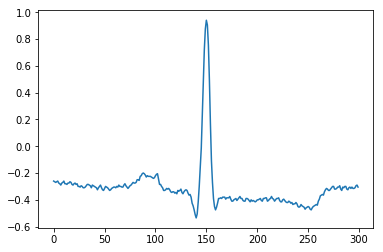

qrs_data    [-0.15, -0.17, -0.175, -0.175, -0.16, -0.15, -...
qrs_type                                                 V1_N
Name: 3, dtype: object


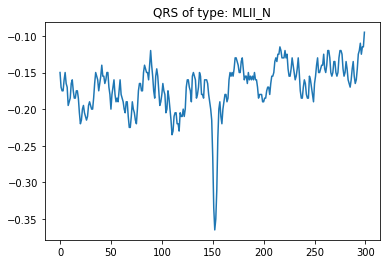

qrs_data    [-0.835, -0.855, -0.865, -0.88, -0.88, -0.87, ...
qrs_type                                               MLII_L
Name: 4, dtype: object


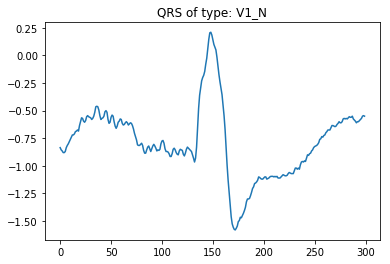

qrs_data    [-0.215, -0.21, -0.21, -0.215, -0.22, -0.24, -...
qrs_type                                                 V1_L
Name: 7, dtype: object


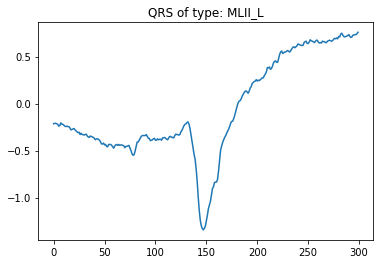

qrs_data    [-0.885, -0.9, -0.905, -0.89, -0.9, -0.905, -0...
qrs_type                                               MLII_R
Name: 8, dtype: object


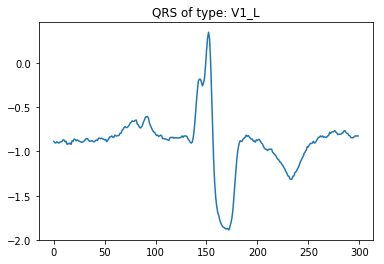

qrs_data    [-0.18, -0.18, -0.17, -0.195, -0.24, -0.25, -0...
qrs_type                                               MLII_V
Name: 188, dtype: object


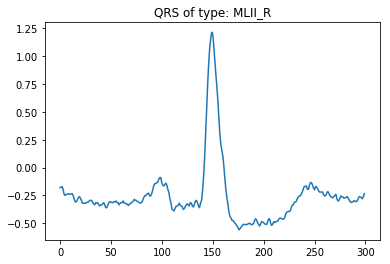

qrs_data    [0.13, 0.115, 0.12, 0.125, 0.13, 0.125, 0.135,...
qrs_type                                                 V1_V
Name: 351, dtype: object


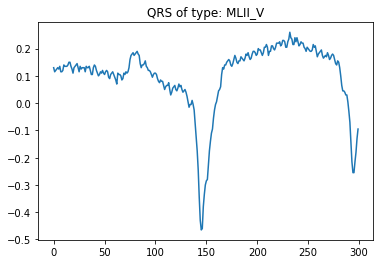

qrs_data    [-0.185, -0.18, -0.185, -0.19, -0.205, -0.195,...
qrs_type                                                 V5_N
Name: 17, dtype: object


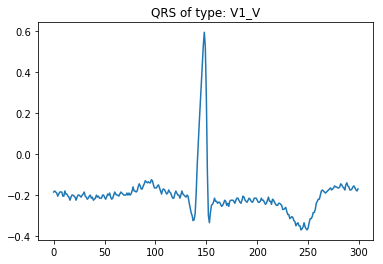

qrs_data    [-0.53, -0.535, -0.515, -0.47, -0.475, -0.47, ...
qrs_type                                                 V1_R
Name: 17, dtype: object


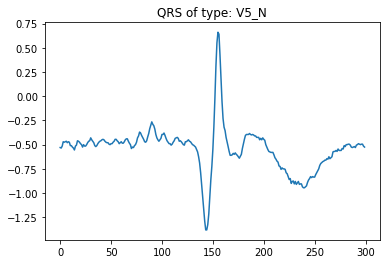

IndexError: index 9 is out of bounds for axis 0 with size 9

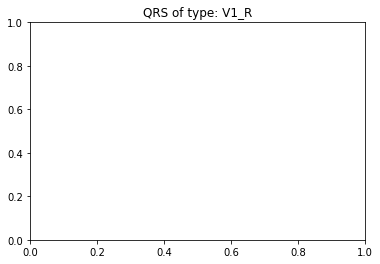

In [92]:
for i in range(100):
    partial, qrs_type = get_class(i)
    qrs = partial.iloc[i]['qrs_data']
    print(partial.iloc[i])
    plt.plot(qrs)
    plt.show()
    #plt.imshow(rec_plot(qrs))
    plt.title('QRS of type: {}'.format(qrs_type))

In [93]:
base_new= base[base['qrs_type'].isin(list(classes.index))]

In [94]:
base_new.qrs_type.unique().shape

(9,)

In [95]:
X= np.vstack(list(base_new['qrs_data']))

In [96]:
Y= np.array(base_new['qrs_type'])

In [97]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
Y= le.fit_transform(Y)
from keras.utils.np_utils import to_categorical
Y = to_categorical(Y)

In [98]:
X = X[:,:,np.newaxis]

In [99]:
# simple cross-validation.(k-fold cross validation not used because of lot of time being taken for training k*timenow)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=531)

In [100]:
# model = Sequential()
# model.add(Dense(32, activation='relu', input_dim=300))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='rmsprop',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [101]:
x_train.shape[1:]

(300, 1)

In [102]:
model = Sequential()
model.add(Conv1D(filters=2, kernel_size=14, activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool1D(strides=1))
model.add(BatchNormalization())
model.add(Conv1D(filters=4, kernel_size=7, activation='relu'))
model.add(MaxPool1D(strides=1))
model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=7, activation='relu'))
model.add(MaxPool1D(strides=1))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(21,  activation='sigmoid'))

In [70]:
model.compile(optimizer=Adam(4e-5), loss = 'categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, 128, 
                           validation_data=(x_test, y_test), 
                           verbose=1, epochs=2)

ValueError: Error when checking target: expected dense_3 to have shape (21,) but got array with shape (9,)

In [103]:
hist = model.fit(x_train, y_train, 128, 
                           validation_data=(x_test, y_test), 
                           verbose=1, epochs=10)

RuntimeError: The model needs to be compiled before being used.

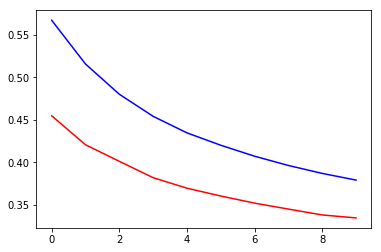

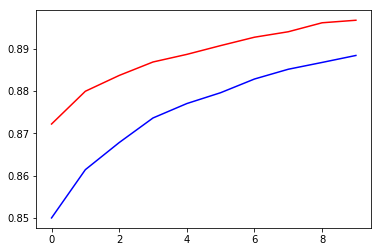

In [108]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [27]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
y_hat = model.predict(x_test)[:,0]

NameError: name 'y_test' is not defined